# Background and Tools
There are two algorithms with similar names, which makes them prone to confusion although they have different purposes and follow different learning paradigms. One is in fact a clustering algorithm, k-Means, which in an unsupervised manner finds k clusters in a data set. This is done by iteratively setting out / moving k cluster centers and grouping the points in the set closest into the cluster, while at the same time optimising the separation between the groups (clusters) of data points. The other is a classifier, k-NN, which in its basic conceptual form does not actually do anything to fit a model to the given data, it simply finds the k nearest neighbours in the entire data set to an unseen data point, given some distance measure, and assigns it the class of the majority of the k samples. In actual implementations, other techniques are used to structure the data somewhat, so that the search for the closest points only has to be carried out in a part of the data set. However, it can be called supervised, as it is given the class labels of the data points it works with to do this pre-processing.

You will in this assignment work with a simplified version of the MNIST handwritten numbers dataset provided by SciKitLearn (sklearn.datasets.digits) and inspect and modify it with UMAP, calculate the cosine similarity of each data sample against the means over the different classes, and later both cluster it with k-Means as well as use the k-NN classifier on it, to then run different evaluation tools. The idea is to have used UMAP (as one example of a tool for dimensionality reduction), done a matrix multiplication in Python / Numpy, understand the different elements of the SciKitLearn confusion matrix and evaluation reports, as well as to see what you can do to evaluate a clustering approach (which is not as naturally done as for a classification, where an answer is either wrong or correct). 

# Exercise 1: Getting started


### Exercise 1.1
Make sure to have all the necessary basic tools running with the ["Lab 0: Python intro"](https://canvas.education.lu.se/courses/32297/pages/lab-0-python-intro) exercise. If not already included in your setup, install UMAP (e.g. with ```pip install umap-learn```, see https://umap-learn.readthedocs.io/en/latest/basic_usage.html for some hints).

In [7]:
# Install with pip install scikit-learn pandas seaborn umap-learn IProgress
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, metrics
from collections import Counter # For majority counting, but is not strictly necessary
import matplotlib.pyplot as plt 
import numpy as np

import seaborn as sns
import pandas as pd
import umap

### Exercise 1.2
Load the digits dataset from the datasets provided in SciKitLearn. [The python tutorial by Dennis Medved](Python_introduction.ipynb) can provide you with code snippets and inspiration to this and later parts of the assignment.

Inspect the data, plot some sample images (use matplotlib) and be prepared to answer questions about the dataset.

Loads a dataset with about **1800**, **8x8 pixel** image of **handwritten numbers**.

(1797, 8, 8)
[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


<Figure size 640x480 with 0 Axes>

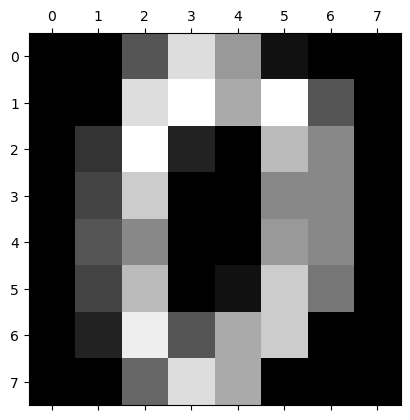

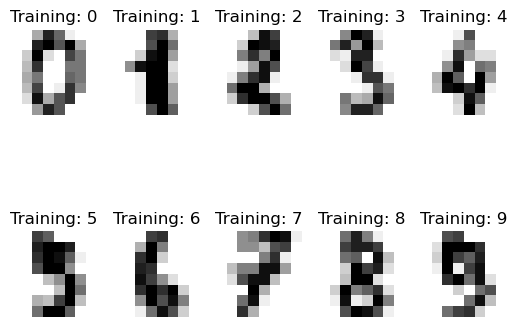

In [8]:
digits = datasets.load_digits()

# There are around 1800 samples in the dataset, around 180 for each digit
# digits.images corresponds to the "unflattened" images (8x8 pixels instead of 64x1)
print(digits.images.shape)
print(digits.images[0])
plt.gray()
plt.matshow(digits.images[0])
plt.show()


images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

### Exercise 1.3
Create and train (fit) a UMAP-reducer, then transform and visualise your data, e.g. doing something like:


UMAP is a general purpose manifold learning and **dimension reduction algorithm**.

c:\Users\joaqu\anaconda3\envs\ML\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(1797, 64)
(1797, 2)


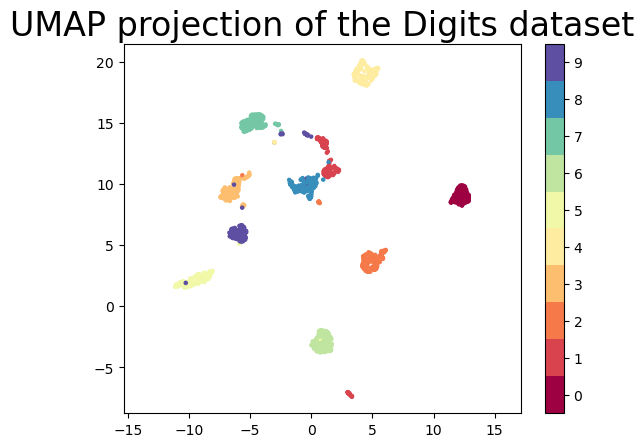

In [9]:
reducer = umap.UMAP(random_state=42) # Inititate the UMAP class

# Now we need to train our reducer, letting it learn about the manifold. For this UMAP follows the sklearn API and has a method fit which we pass the data we want the model to learn from
reducer.fit(digits.data) 
embedding = reducer.transform(digits.data)
# There is a fit_transform method which combines the two steps above, but we will use the two-step approach here for clarity, the transfrom method is used to project new data into the learned manifold
print(digits.data.shape) # 1797 samples, 64 features
print(embedding.shape) # 1797 samples, 2 features

plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

# Basically UMAP reduces each image from a 64 dimensional space (8x8 pixels where each pixel correspondes to a feature) to a 2D space,
# where the distance between the points in the 2D space is a good approximation of the distance between the images in the 64D space
# Worth commenting:
# The shape (1797, 64) describes a 2D matrix in terms of rows and columns, where each row is an image and each column is a pixel.
# However, each row (each digit/image) is thought of as a vector in a 64-dimensional feature space. This means each row has 64 independent "directions", each corresponding to a pixel. 


__Be prepared to explain, at least on a conceptual level, what it does__

# Exercise 2
Calculate the cosine-similarity (should be explained in lecture 2) of each sample against the means of the classes in the data set as following:

### Exercise 2.1
Calculate the "mean image" per class, ```mean_images``` 

In [10]:
# This command basically creates a list of tuples where the first position is the image and the second is the label
images_and_labels = list(zip(digits.data, digits.target))

# Convert it to a pandas dataframe
digits_df = pd.DataFrame(images_and_labels, columns=['image', 'label'])

# We can now use the groupby method to group the dataframe by the label column ("target" in the original dataset)
# It essentially organizes rows with the same target value together, making it easy to perform calculations or operations on each group
digits_grouped_by_label = digits_df.groupby('label')

# Now we can use the mean method to calculate the mean of each group, which in this case is the mean image for each digit
# This calculates the mean of each pixel across all images for each digit label. This will give us a "typical" image for each digit
mean_images = digits_grouped_by_label.mean() # The mean will by default be done column wise, so we get the mean of each pixel for each digit
print(mean_images)


                                                   image
label                                                   
0      [0.0, 0.02247191011235955, 4.185393258426966, ...
1      [0.0, 0.01098901098901099, 2.456043956043956, ...
2      [0.0, 0.9322033898305084, 9.666666666666666, 1...
3      [0.0, 0.644808743169399, 8.387978142076502, 14...
4      [0.0, 0.0, 0.4530386740331492, 7.0552486187845...
5      [0.0, 0.967032967032967, 9.983516483516484, 13...
6      [0.0, 0.0, 1.138121546961326, 11.1657458563535...
7      [0.0, 0.16759776536312848, 5.100558659217877, ...
8      [0.0, 0.14367816091954022, 5.022988505747127, ...
9      [0.0, 0.14444444444444443, 5.683333333333334, ...


### Exercise 2.2
Calculate the row-wise L2-norm for the raw data, i.e. the L2-norm over each image (check for example Numpy's linalg.norm for that) __and__ for the mean images you got from step the previous step.

In [11]:
raw_data = digits.data
# We can calculate the L2 norm of each image, which is the square root of the sum of the squares of the pixel values
# This is a measure of the "length" of the vector (image) in the 64D space
# axis=1 means we calculate the norm for each row (each image), axis=0 would mean we calculate the norm for each column (each pixel)
raw_data_l2_norms = np.linalg.norm(raw_data, ord=2, axis=1); 
print(raw_data_l2_norms)

# np.stack converts the series of arrays into a 2D array, where each row is an image
mean_image_data = np.stack(mean_images['image'].values)
mean_images_l2_norms = np.linalg.norm(mean_image_data, ord=2, axis=1)
print(mean_images_l2_norms)


[55.40758071 64.87680633 66.24198065 ... 71.3582511  65.69627082
 70.27090436]
[57.21007138 56.76243429 56.13686576 55.6744608  55.96995923 54.6351969
 57.73202669 54.9510358  57.26457834 54.64989411]


### Exercise 2.3
Calculate the cosine similarity matrix, ```similarities``` of the normalised raw data and mean image matrices. See https://en.wikipedia.org/wiki/Cosine_similarity. as a reminder. 
Cosine similarity is **the cosine of the angle between the vectors; that is, it is the dot product of the vectors divided by the product of their lengths**.

In [12]:
raw_data = digits.data
mean_images = np.stack(mean_images['image'].values)

# List comprehension to compute the similarities matrix
similarities = [[np.dot(raw_data[i], mean_image_data[j]) / (raw_data_l2_norms[i] * mean_images_l2_norms[j]) for j in range(mean_image_data.shape[0])] for i in range(raw_data.shape[0])]
# Convert to numpy array
similarities = np.array(similarities)
print(similarities)




[[0.96953736 0.64057712 0.69033218 ... 0.69534056 0.78048386 0.82650128]
 [0.61422565 0.95983463 0.80485635 ... 0.77964591 0.85403808 0.73784076]
 [0.70985123 0.87401958 0.82590236 ... 0.77998321 0.85962083 0.72941315]
 ...
 [0.78054372 0.91604527 0.84017123 ... 0.80155401 0.94412191 0.80488239]
 [0.85063932 0.80267119 0.75221714 ... 0.76388727 0.86535741 0.92850174]
 [0.81182654 0.84447725 0.84761052 ... 0.75906702 0.92310303 0.86380316]]


### Exercise 2.4
Plot the closest and "furthest" sample (images) for each class, i.e. where cosine similarity is highest / lowest together with the respective mean image. You can use the following plot routine as inspiration to get the images out with some meta data (```similarities``` is the matrix with all the cosine similarities):

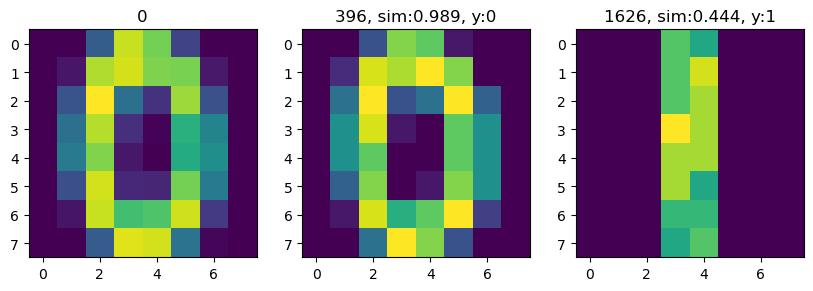

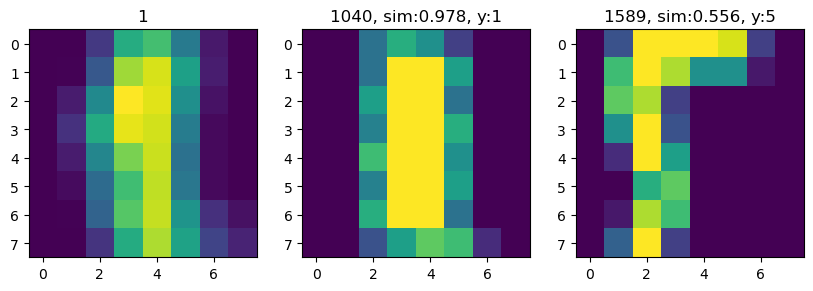

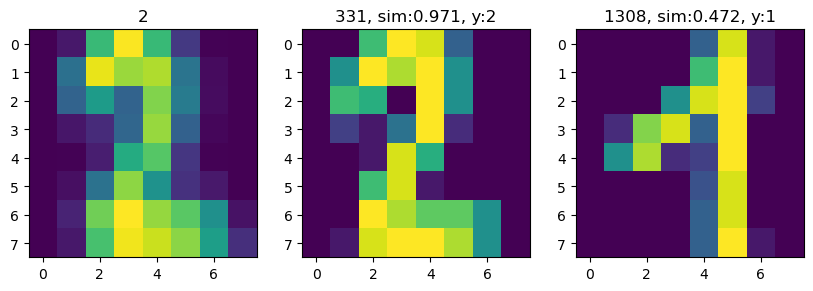

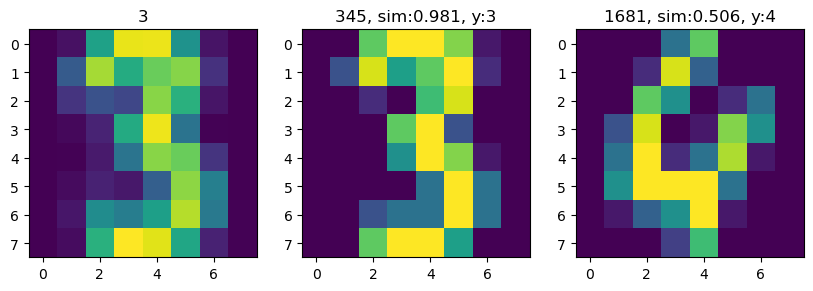

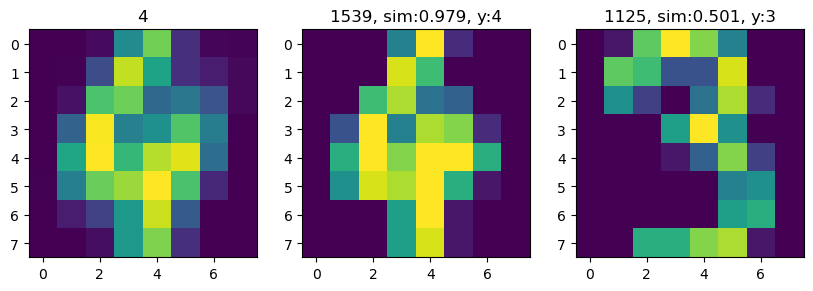

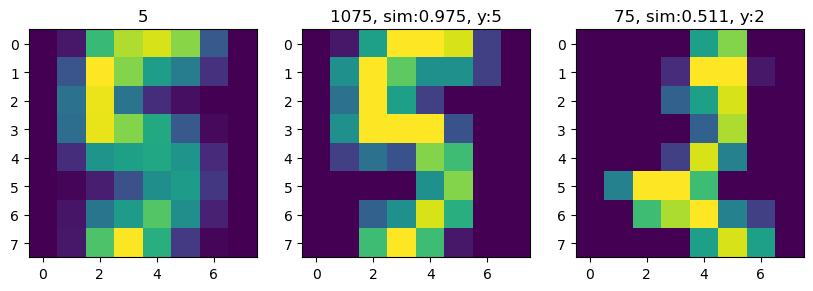

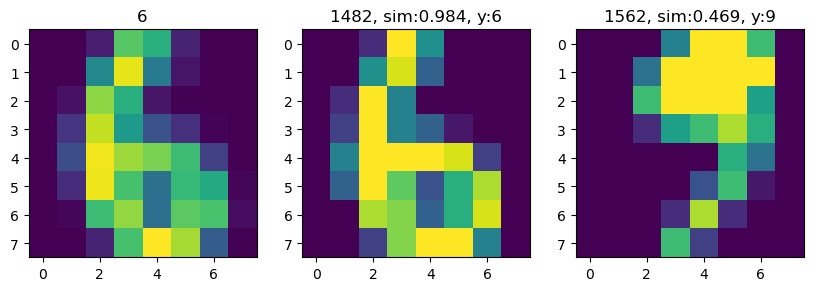

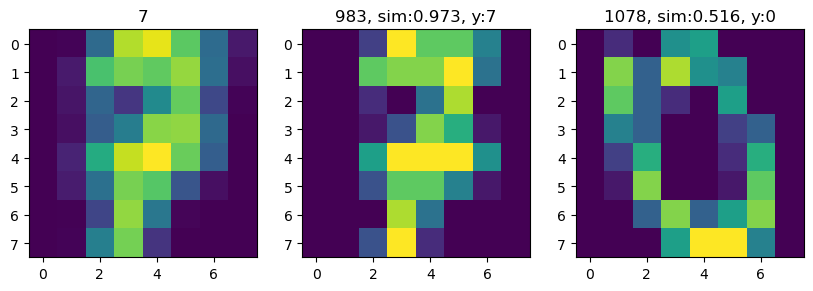

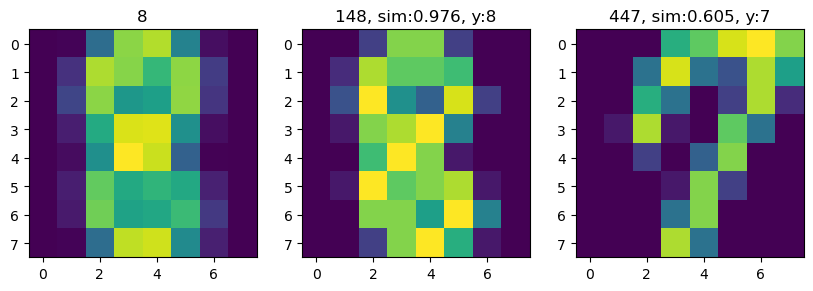

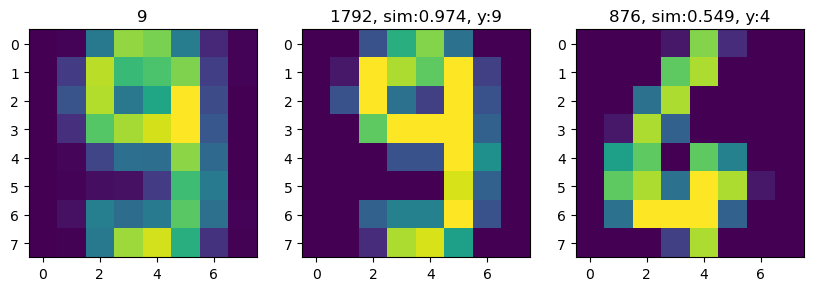

In [13]:
for i in range(0, 10):

    min_idx = np.argmin(similarities[:,i])
    max_idx = np.argmax(similarities[:,i])

    fig, axs = plt.subplots(1,3,figsize=(10,10))
    
    # reference image
    axs[0].set_title(f"{i}")        
    axs[0].imshow(mean_images[i].reshape(8,8), cmap='viridis')
    
    # image and data with highest similarity to reference
    axs[1].set_title(f"{max_idx}, sim:{similarities[max_idx, i]:.3f}, y:{digits.target[max_idx]}")
    axs[1].imshow(raw_data[max_idx].reshape(8,8), cmap='viridis')
    
    # image and data with lowest similarity to reference
    axs[2].set_title(f"{min_idx}, sim:{similarities[min_idx, i]:.3f}, y:{digits.target[min_idx]}")
    axs[2].imshow(raw_data[min_idx].reshape(8,8), cmap='viridis')

plt.show()

__Be prepared to explain__ what you see and reflect upon it!

# Exercise 3
Split your data set into 70% training data (features and labels), and 30% test data (this will be used for the classifiers below).

In [14]:
num_samples = len(digits.data)
num_split = int(0.7*num_samples)

train_features = digits.data[:num_split]
train_labels =  digits.target[:num_split]
test_features = digits.data[num_split:]
test_labels = digits.target[num_split:]

# For better undertsanding about how slicing works:
x = [1,2,3,4,5]
x = np.array(x)
# This method has the signature: sequence[start:stop:step]
# start: the index where the slice starts (inclusive)
# stop: the index where the slice ends (exclusive)
# step: the step size for the slice
print(x[:2])
print(x[2:])


[1 2]
[3 4 5]


# Exercise 4: k-NN
Process the data with a k-NN classifier as follows: 

### Exercise 4.1
Set up a ```sklearn.neighbors.KNeighborsClassifier``` as it comes in SciKitLearn with ```n_neighbors = 5, algorithm = 'brute'``` and otherwise default parameters

In [15]:
classifier = KNeighborsClassifier(algorithm='brute') # n_neighbors is set to 5 by default

### Exercise 4.1
Prepare the classifier ("fit a model") with your training data, i.e. do something like  

In [35]:
classifier.fit(train_features, train_labels) # Fit the k-nearest neighbors classifier from the training dataset.


KNeighborsClassifier(algorithm='brute')

### Exercise 4.2
 Apply your classifier to the test data, i.e., get predictions for the test data with 

In [36]:
predictions = classifier.predict(test_features) # Predict the class labels for the provided data
predictions


array([4, 0, 5, 3, 6, 9, 6, 1, 7, 5, 4, 4, 7, 2, 8, 2, 2, 5, 7, 9, 5, 4,
       8, 8, 4, 9, 0, 8, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5,
       0, 9, 8, 9, 8, 4, 1, 7, 7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2,
       6, 3, 3, 7, 3, 3, 4, 6, 6, 6, 4, 9, 1, 5, 0, 9, 6, 2, 8, 3, 0, 0,
       1, 7, 6, 3, 2, 1, 7, 4, 6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, 1, 4, 0,
       5, 3, 6, 9, 6, 1, 7, 5, 4, 4, 7, 2, 8, 2, 2, 5, 7, 9, 5, 4, 1, 8,
       4, 9, 0, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
       8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9,
       8, 4, 1, 7, 7, 3, 5, 1, 0, 0, 2, 2, 7, 9, 2, 0, 1, 2, 6, 3, 3, 7,
       3, 3, 4, 6, 6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 9, 7, 6, 3,
       2, 1, 7, 4, 6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3, 6, 9,
       6, 1, 7, 5, 4, 4, 7, 2, 8, 2, 2, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, 8,
       9, 8, 0, 1, 2, 3, 4, 5, 6, 7, 1, 9, 0, 1, 2,

Get the nearest neighbors and the corresponding distances in the training set for each test sample by using  

In [37]:
#Usage <distances, neighbors> = <classifier>.kneighbors( <test_features>) 

# This method returns two arrays:
# distances: the distances between the test samples and the k nearest neighbors for each test sample
# indices: the locations of the k nearest neighbors in the training dataset
distances, indices = classifier.kneighbors(test_features) # Finds the K-neighbors of a point.
print(distances)
print(indices)



[[11.66190379 16.94107435 18.16590212 19.31320792 20.19900988]
 [21.09502311 21.47091055 21.61018278 21.74856317 21.81742423]
 [18.02775638 18.1934054  19.62141687 21.16601049 21.9317122 ]
 ...
 [20.83266666 21.70253441 22.93468988 24.0208243  25.63201124]
 [19.5192213  21.09502311 23.87467277 24.69817807 24.8394847 ]
 [26.73948391 27.62245463 27.73084925 27.80287755 27.92848009]]
[[ 353  817  297  366 1254]
 [1177  588  725  824  335]
 [ 376  791  801  165  896]
 ...
 [ 148  248  242 1069  255]
 [ 254  251  849  417  199]
 [ 183  248 1015  513  224]]


Visualize the 5 nearest neighbors for a few test images (see tutorial)!

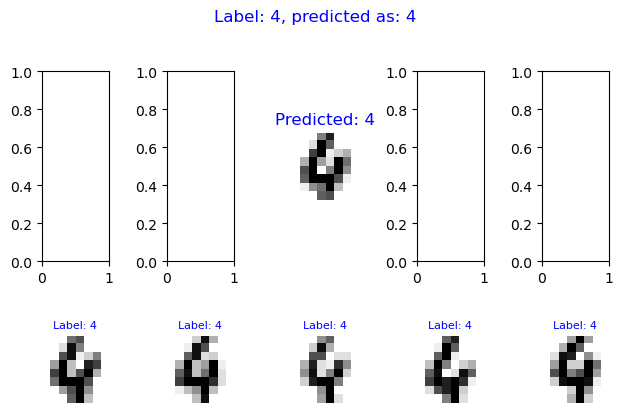

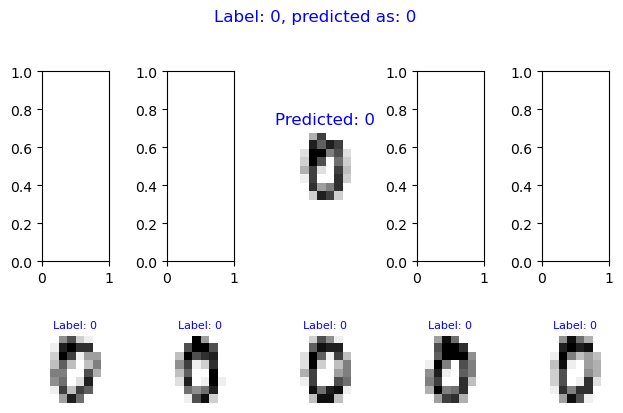

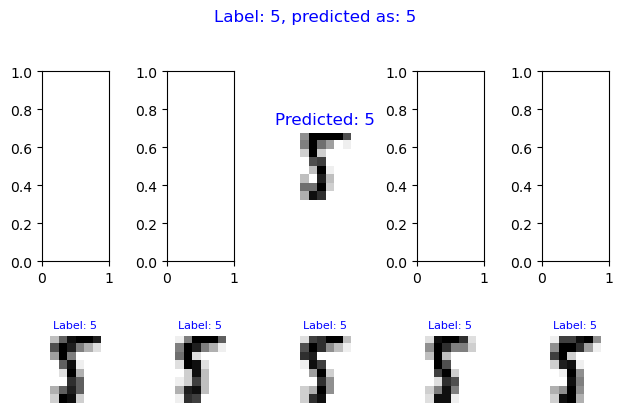

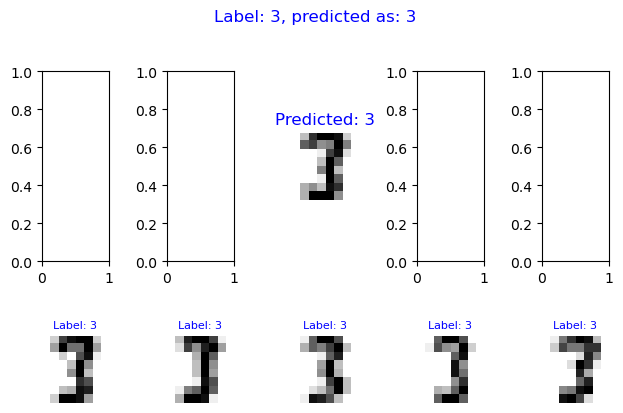

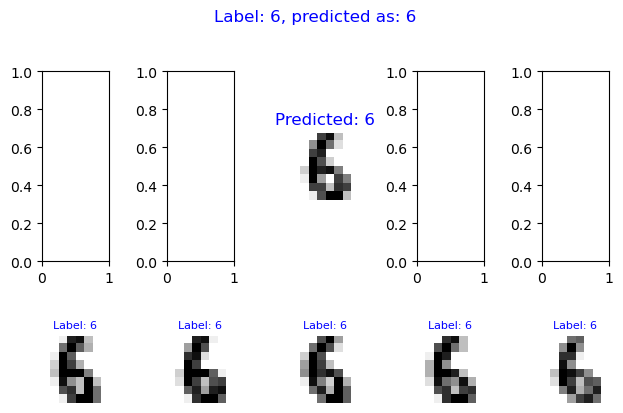

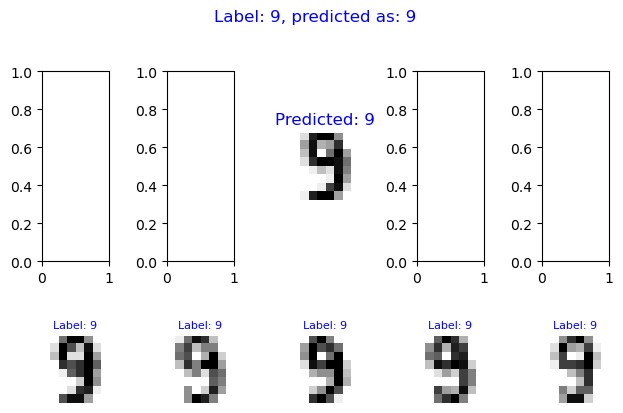

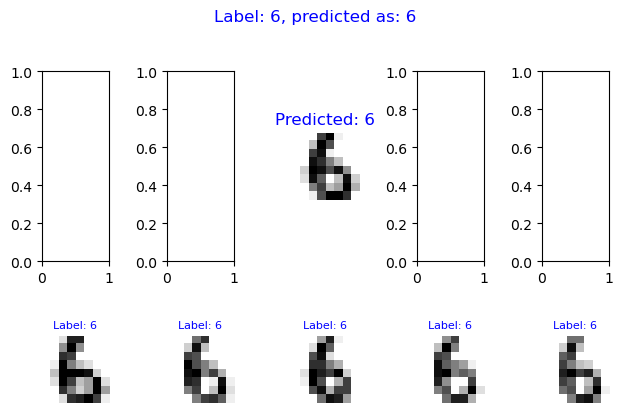

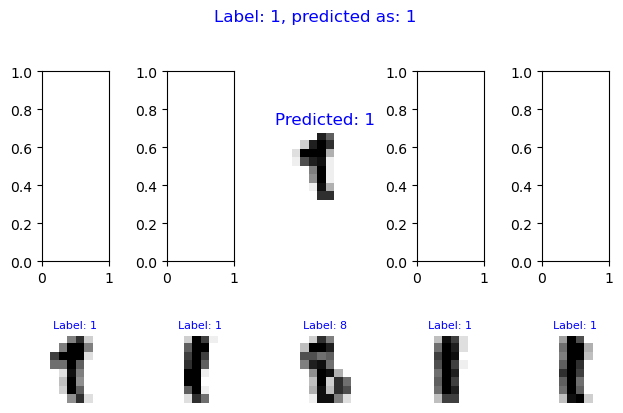

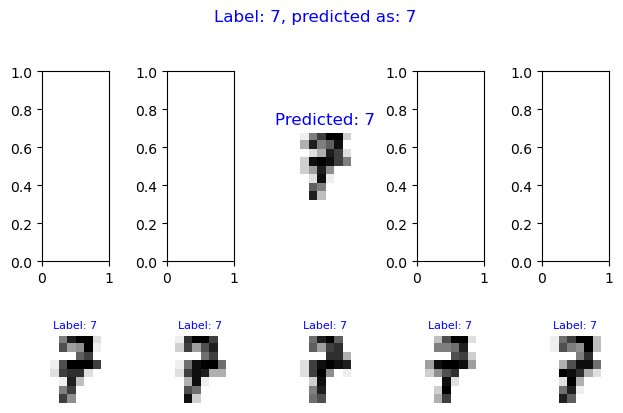

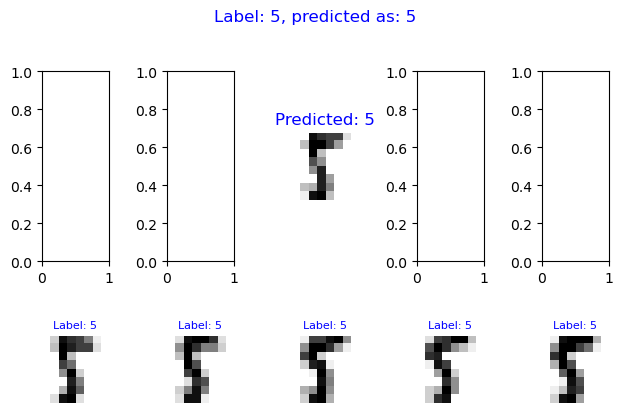

In [ ]:
# This basically creates a list of tuples where the first position is the 8x8 image and the second is its corresponding label
# The images being used are the same ones included in the test_features variable
images_and_predictions = list(zip(digits.images[num_split:], predictions, indices))
for index, (image, prediction, neighbors_index) in enumerate(images_and_predictions[:10]):
    fig, axs = plt.subplots(2, 5) # Create a figure and a set of subplots
    fig.suptitle(f"Label: {test_labels[index]}, predicted as: {prediction}", color='blue')
    
    # Display the main test image
    axs[0, 2].imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    axs[0, 2].axis('off')
    axs[0, 2].set_title(f"Predicted: {prediction}", color='blue')

    # Display each of the 5 nearest neighbors
    for i in range(5):
        # A bit confusing but a neighbors_index is a list of indices of the neighbours that led to the prediction. So in order to display them I need to retrieve the 
        # index of each neighbour in this list and then use it to retrieve the image from the dataset
        axs[1, i].imshow(digits.images[neighbors_index[i]], cmap=plt.cm.gray_r, interpolation='nearest')
        axs[1, i].axis('off')
        axs[1, i].set_title(f"Label: {digits.target[neighbors_index[i]]}", fontsize=8, color='blue')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust spacing to fit the title
    plt.show()

# Have to set axis('off') to remove the axis labels in each subplot of the figure


        

### Exercise 4.3
Evaluate your classifier with the sklearn.metrics tools classification_report and confusion_matrix:  

In [ ]:
# Usage metrics.classification_report( <test_labels>, <predicted_labels>) 
print(metrics.classification_report(test_labels, predictions))
# This method returns a text report showing the main classification metrics



              precision    recall  f1-score   support

           0       0.98      0.98      0.98        53
           1       0.95      0.98      0.96        53
           2       0.98      0.96      0.97        53
           3       0.96      0.92      0.94        53
           4       0.98      0.96      0.97        57
           5       0.95      0.98      0.96        56
           6       0.98      1.00      0.99        54
           7       0.95      1.00      0.97        54
           8       0.96      0.90      0.93        52
           9       0.96      0.95      0.95        55

    accuracy                           0.96       540
   macro avg       0.96      0.96      0.96       540
weighted avg       0.97      0.96      0.96       540



and

In [ ]:
# USage metrics.confusion_matrix( <test_labels, <predicted_labels>)
print(metrics.confusion_matrix(test_labels, predictions))
# This method returns the confusion matrix to evaluate the accuracy of a classification
# By definition a confusion matrix C is succh that C(i,j) is equal to the number of observarions known to be in group i but predeicted to be in group j
# In other words, 
# The diagonal elements represent the number of points for which the predicted label is equal to the true label,
# while off-diagonal elements are those that are misclassified by the classifier


[[52  0  0  0  1  0  0  0  0  0]
 [ 0 52  0  0  0  0  0  0  0  1]
 [ 1  0 51  1  0  0  0  0  0  0]
 [ 0  0  1 49  0  1  0  1  1  0]
 [ 0  0  0  0 55  0  0  1  1  0]
 [ 0  0  0  0  0 55  1  0  0  0]
 [ 0  0  0  0  0  0 54  0  0  0]
 [ 0  0  0  0  0  0  0 54  0  0]
 [ 0  3  0  0  0  0  0  1 47  1]
 [ 0  0  0  1  0  2  0  0  0 52]]


# Exercise 5: k-Means
Cluster the data with k-Means as follows:

### Exercise 5.1
Set up a k-Means instance (```sklearn.cluster.KMeans```) with ```n_clusters=10```, default parameters otherwise.

In [59]:
#*** Your code ***
# Create a KMeans model with 10 clusters
model = KMeans(n_clusters=10, n_init=100, random_state=42)


### Exercise 5.2
Apply the clustering approach with

In [73]:
#<clusters> = <clustering>.fit(<train_features>)
# Unlike supervised learning, clustering is an unsupervised learning method,
# which means it doesn't use true labels (e.g., train_labels) when creating the clusters.
# Therefore, you only fit the model on train_features, not train_labels.
clusters = model.fit(train_features)
print(clusters)


KMeans(n_clusters=10, n_init=100, random_state=42)


### Exercise 5.3
Visualise the found cluster centers (you can get them using <clustering>.cluster_centers_); those are in principle also images, but maybe not as clearly interpretable as you would have hoped for. Compare what you see with the scatter plot you got from UMAP, i.e. find k-Means-clusters (visualised as cluster center images) and corresponding UMAP-plot-clusters (visualised as blobs or scattered dots in the plot) that are clearly distinct from everything else or others that seem to be "all the same" or at least very close.

(10, 64)


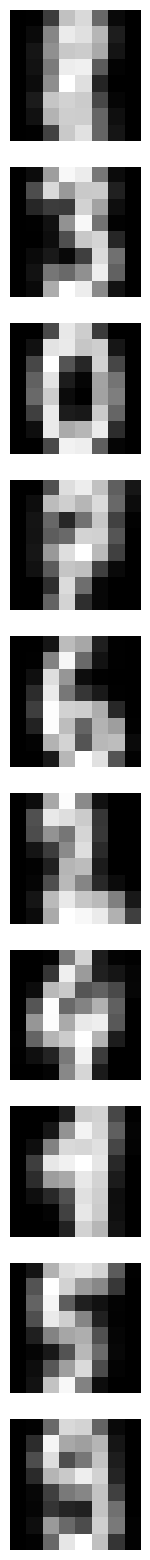

In [ ]:
cluster_centers = clusters.cluster_centers_
print(cluster_centers.shape)

# Probably also uses the euclidean distance to calculate the distance between the features ????
# Set the figure size to make subplots larger
plt.figure(figsize=(5, 20))  # Adjust width and height as needed
for i in range(10):
    plt.subplot(10, 1, i+1)
    plt.imshow(cluster_centers[i].reshape(8,8))
    plt.axis('off')
plt.show()

# 2,1,8 are not very clear, but the rest are quite clear
# They are probably quite close to each other in the UMAP space, which is why they are clustered together


### Exercise 5.4
Investigate at least the following evaluation tools in the SciKitLearn documentation:

For those to work you should run a prediction step over the training data (into cluster-labels), to have a bit more data to look at. Rough numbers for what those measures should be can be found in the check list below. .

In [77]:
cluster_labels = clusters.predict(train_features)

# Compute completeness metric of a cluster labeling given a ground truth
# A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster
# The value of the completeness metric is in the range [0, 1]. 1 stands for perfectly complete labeling
print(metrics.completeness_score(train_labels, cluster_labels))

# Homogeneity metric of a cluster labeling given a ground truth
# A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class
# The value of the homogeneity metric is in the range [0, 1]. 1 stands for perfectly homogeneous labeling.
# Meaning that the clusters are pure, i.e. all data points in a cluster belong to the same class
print(metrics.homogeneity_score(train_labels, cluster_labels))




0.7562870200200442
0.7470599279960811


For the interested: Try also the following score (the main concept is the mutual information score, the adjusted mutual information score is an improved variant) and give its documentation some thoughts, discuss it with your partner and in the peer review (it should make more sense after the information theory lecture, but there is also some intuition in it, that you can reflect upon)

In [ ]:
# Usage metrics.adjusted_mutual_info_score( <labels>, <cluster-labels>)
# Seems to take into account the amount of clusters and therefore the probability of they overlapping by chance
print(metrics.adjusted_mutual_info_score(train_labels, cluster_labels))


0.7480304894143706


### Exercise 5.5
For each cluster, assign a label by taking the most common label of the training data assigned to the cluster. 


In [ ]:
# *****************
print(cluster_labels)
print(cluster_labels.shape)

cluster_label_to_true_label = {}

for cluster in range(10):
    # Get the indices of the samples in the cluster
    cluster_indices = np.where(cluster_labels == cluster)
    # Get the true labels of the samples in the cluster
    true_labels = train_labels[cluster_indices]
    # Find the most common true label in the specified cluster
    # Counter returns a dictionary with true labels as keys and their counts as values
    # most_common(1) returns a list with the most common elements in descending order
    # [0] returns the first tuple of the list
    # [0] returns the first element of the tuple, which is the most common true label
    most_common_true_label = Counter(true_labels).most_common(1)[0][0]

    # Assign the most common true label to the cluster
    cluster_label_to_true_label[cluster] = most_common_true_label

print(cluster_label_to_true_label)
# Remember, the cluster label is not any label predicted by the model, but a label assigned to each cluster by the model
# We are basically just assigning each cluster to a label based on the true label of its elements




[2 0 0 ... 6 1 0]
(1257,)
{0: 8, 1: 3, 2: 0, 3: 7, 4: 6, 5: 2, 6: 4, 7: 1, 8: 5, 9: 9}


### Exercise 5.6
Use the clustering result to do a prediction for the test data and evaluate the result. It should be quite bad. Think about an explanation for this low quality and find solutions (hint: the search phrase "assigning class label to cluster" in a well known search engine would do just fine). 

4
0
5
3
6
9
6
5
7
5


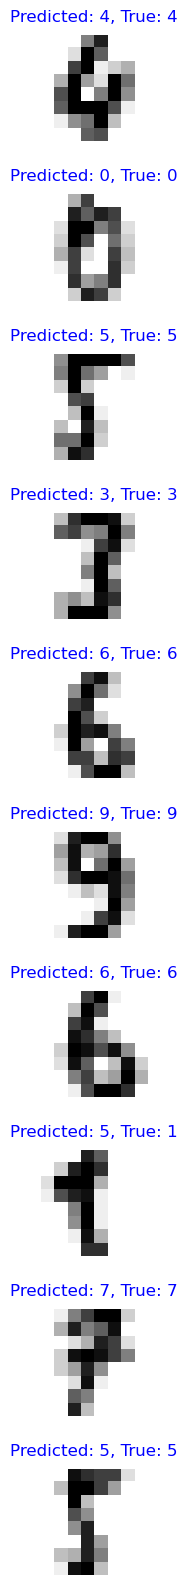

In [100]:
# This will evaluate the test features and try to place them in the clusters that were created by the model
predictions = clusters.predict(test_features)

# Increase the figure size
plt.figure(figsize=(6, 20))  # Width and height in inches, adjust as needed

for index, prediction in enumerate(predictions[:10]):
    # This returns the true label that was computed in the step before, based on the most common true label in the cluster
    label_according_to_cluster = cluster_label_to_true_label[prediction]
    print(label_according_to_cluster)

    # Retrieve the current image from the test features
    image = digits.images[num_split + index]

    # Display the predicted label, its corresponding image, and the true label
    plt.subplot(10, 1, index + 1)
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.axis('off')
    plt.title(f"Predicted: {label_according_to_cluster}, True: {test_labels[index]}", color='blue', pad=10)

plt.subplots_adjust(hspace=.5)  # Increase vertical spacing between subplots
plt.show()

